# **Dataset context**

The Garbage Classification dataset was created to support the development of machine learning models for automated waste sorting and recycling systems. It consists of labeled images of various types of garbage, such as cardboard, glass, metal, paper, plastic and general trash. The goal is to train models to recognize and classify these waste types based on visual characteristics.

This dataset is particularly useful for computer vision applications in environmental sustainability, where automatic identification of recyclable materials can aid in improving waste management efficiency, reducing human error and supporting smart bin technologies. Its real-world variability—such as different lighting, angles, and backgrounds—makes it suitable for building robust image classification systems.

# **Dataset content**

* **Total Classes**: 6 categories of garbage:

 - 1. cardboard

 - 2. glass

 - 3. metal

 - 4. paper

 - 5. plastic

 - 6. trash

* **File Format**: Images are stored as .jpg files. Typical image dimensions vary (e.g., ~384x512 pixels), but can be resized for modeling.

* **Labeling**: Each folder name serves as the class label for the images it contains.

* **Number of Images**: ~2,500–2,600 total images (approx. 400–500 per class).

* **Image Variety**: Photos include various object shapes, sizes, and backgrounds to mimic real-world conditions. Some images show used/dirty items, others are clean, making it suitable for generalization.

*(source: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification/data)*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import tqdm
import random
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import transform
from sklearn.model_selection import train_test_split
import zipfile
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.layer_utils import count_params
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import tensorflow as tf
from keras import regularizers

from joblib import dump, load

warnings.filterwarnings('ignore')

import os
from IPython.display import display
import ipywidgets as widgets
import zipfile

In [2]:
# Upload kaggle.json
uploader = widgets.FileUpload(accept='.json', multiple=False)
display(uploader)

FileUpload(value={}, accept='.json', description='Upload')

In [4]:
# Save the uploaded file to the correct location
for fname, file in uploader.value.items():
    with open("kaggle.json", "wb") as f:
        f.write(file["content"])

# Create the .kaggle directory on local machine and move the JSON file
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
os.replace("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

In [5]:
# Install Kaggle API
!pip install -q kaggle

In [6]:
# Download dataset
!kaggle datasets download -d asdasdasasdas/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# Unzip the data
with zipfile.ZipFile("garbage-classification.zip", 'r') as zip_ref:
    zip_ref.extractall("garbage_dataset")

In [8]:
# The data consists of 5 text files
for root, dirs, files in os.walk("garbage_dataset"):
    print(f"Directory: {root}")
    print(f"Files: {files[:5]}")
    break

Directory: garbage_dataset
Files: ['one-indexed-files-notrash_test.txt', 'one-indexed-files-notrash_train.txt', 'one-indexed-files-notrash_val.txt', 'one-indexed-files.txt', 'zero-indexed-files.txt']


# EDA

In [9]:
# There are 6 labels of garbage: cardboard, glass, metal, paper, plastic and trash
data_dir  = './garbage_dataset/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [10]:
# Define train, test and val sets
train_dir = './garbage_dataset/one-indexed-files-notrash_train.txt'
test_dir = './garbage_dataset/one-indexed-files-notrash_test.txt'
val_dir = './garbage_dataset/one-indexed-files-notrash_val.txt'

In [11]:
label_map = {1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}

In [12]:
train_df = pd.read_csv(train_dir, header=None, names=['picture', 'label'], delimiter = " ")
train_df.head()

,picture,label
0,cardboard202.jpg,3
1,paper472.jpg,2
2,paper522.jpg,2
3,glass189.jpg,1
4,glass325.jpg,1


In [13]:
# Check for missing values
print(train_df.isnull().sum())

picture    0
label      0
dtype: int64


In [14]:
train_df['label_name'] = train_df['label'].map(label_map)

In [15]:
# There are 1768 photos in train set
print(len(train_df))

1768


In [16]:
# In train set, there are the most glass examples (403) and the least trash examples (91) 
train_df['label'].value_counts()

2    403
1    354
4    347
3    287
5    286
6     91
Name: label, dtype: int64

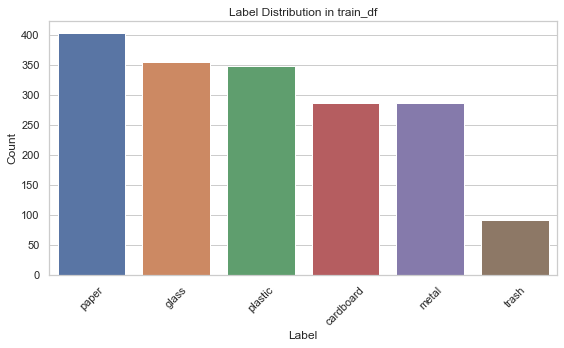

In [17]:
sns.set(style="whitegrid")

# Create the countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='label_name', order=train_df['label_name'].value_counts().index)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in train_df')
plt.xticks(rotation=45)  # Optional: rotate x-axis labels if needed

plt.tight_layout()
plt.show()

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   picture     1768 non-null   object
 1   label       1768 non-null   int64 
 2   label_name  1768 non-null   object
dtypes: int64(1), object(2)
memory usage: 41.6+ KB


       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


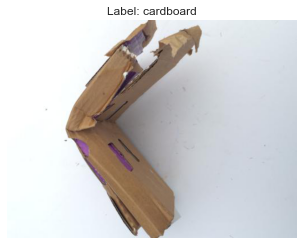

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


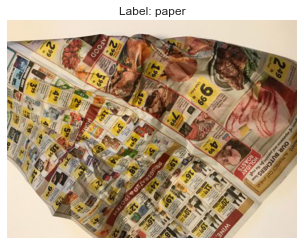

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


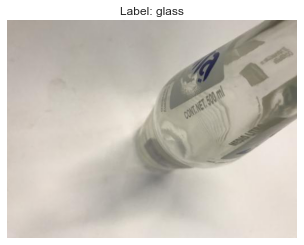

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


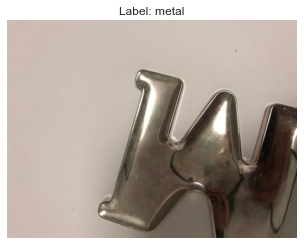

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


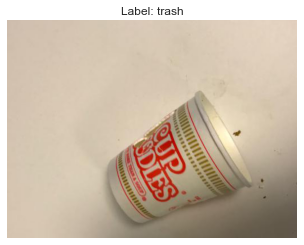

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


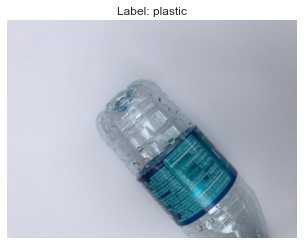

In [19]:
# Display sample images and their distribution per class for train set
classes = train_df['label_name'].unique()

for label in classes:
    sample = train_df[train_df['label_name'] == label].iloc[0]
    img_path = str(data_dir)+'/'+sample['label_name']+"/"+str(sample['picture'])
    dimensions = []
    img = Image.open(img_path)
    dimensions.append(img.size)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    
    dim_df = pd.DataFrame(dimensions, columns=['width', 'height'])
    print(dim_df.describe())
    plt.show()

In [21]:
test_df = pd.read_csv(test_dir, header=None, names=['picture', 'label'], delimiter = " ")
test_df.head()

,picture,label
0,paper70.jpg,2
1,paper380.jpg,2
2,cardboard31.jpg,3
3,glass12.jpg,1
4,paper169.jpg,2


In [22]:
# Check for missing values
print(test_df.isnull().sum())

picture    0
label      0
dtype: int64


In [23]:
test_df['label_name'] = test_df['label'].map(label_map)

In [24]:
# There are 431 photos in test set
print(len(test_df))

431


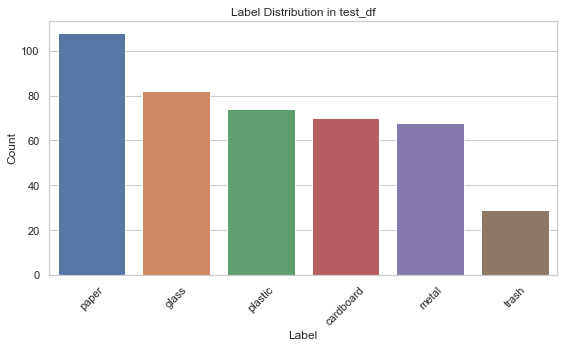

In [25]:
sns.set(style="whitegrid")

# Create the countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=test_df, x='label_name', order=test_df['label_name'].value_counts().index)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in test_df')
plt.xticks(rotation=45)  # Optional: rotate x-axis labels if needed

plt.tight_layout()
plt.show()

In [26]:
# In test set, there are the most glass examples (108) and the least trash examples (29) 
test_df['label'].value_counts()

2    108
1     82
4     74
3     70
5     68
6     29
Name: label, dtype: int64

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   picture     431 non-null    object
 1   label       431 non-null    int64 
 2   label_name  431 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.2+ KB


       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


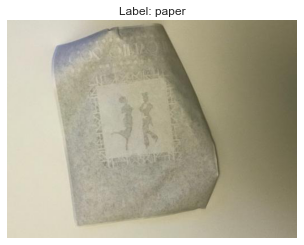

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


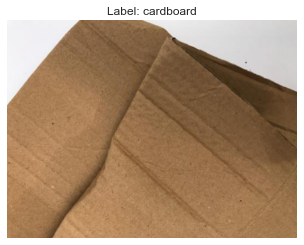

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


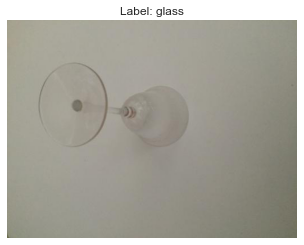

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


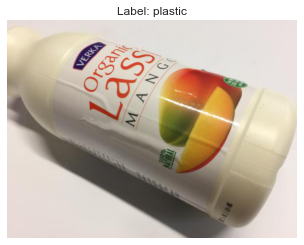

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


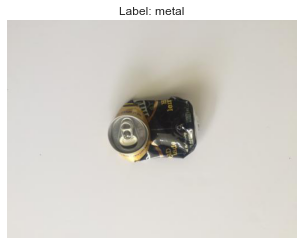

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


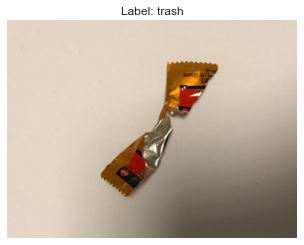

In [28]:
# Display sample images ant their distributions per class for test set
classes = test_df['label_name'].unique()

for label in classes:
    sample = test_df[test_df['label_name'] == label].iloc[0]
    img_path = str(data_dir)+'/'+sample['label_name']+"/"+str(sample['picture'])
    dimensions = []
    img = Image.open(img_path)
    dimensions.append(img.size)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    
    dim_df = pd.DataFrame(dimensions, columns=['width', 'height'])
    print(dim_df.describe())
    plt.show()

In [29]:
val_df = pd.read_csv(val_dir, header=None, names=['picture', 'label'], delimiter = " ")
val_df.head()

,picture,label
0,cardboard114.jpg,3
1,plastic204.jpg,4
2,glass123.jpg,1
3,glass152.jpg,1
4,glass398.jpg,1


In [30]:
# Check for missing values
print(val_df.isnull().sum())

picture    0
label      0
dtype: int64


In [31]:
val_df['label_name'] = val_df['label'].map(label_map)

In [32]:
# There are 328 photos in validation set
print(len(val_df))

328


In [33]:
# In validation set, there are the most glass examples (83) and the least trash examples (17) 
val_df['label'].value_counts()

2    83
1    65
4    61
5    56
3    46
6    17
Name: label, dtype: int64

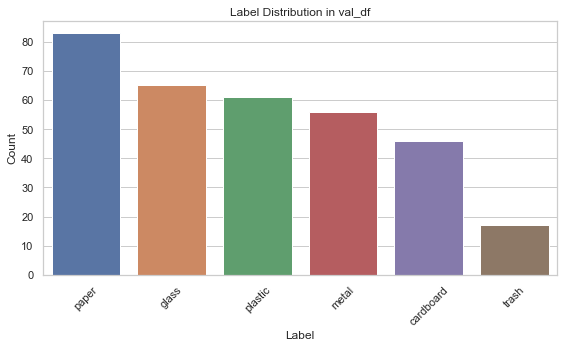

In [34]:
sns.set(style="whitegrid")

# Create the countplot
plt.figure(figsize=(8, 5))
sns.countplot(data=val_df, x='label_name', order=val_df['label_name'].value_counts().index)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in val_df')
plt.xticks(rotation=45)  # Optional: rotate x-axis labels if needed

plt.tight_layout()
plt.show()

In [35]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   picture     328 non-null    object
 1   label       328 non-null    int64 
 2   label_name  328 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.8+ KB


       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


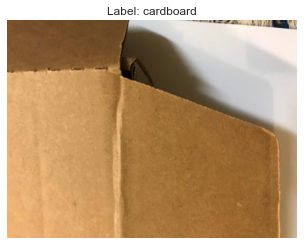

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


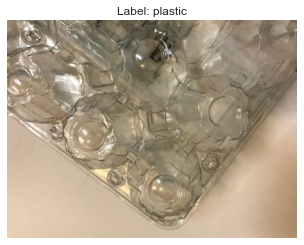

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


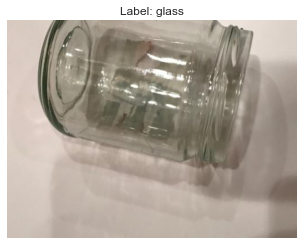

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


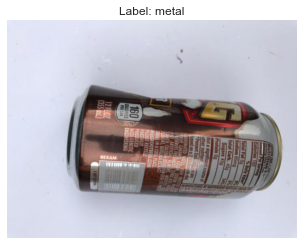

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


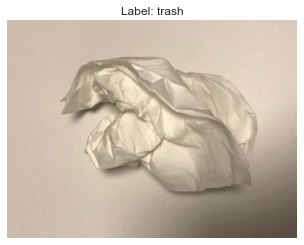

       width  height
count    1.0     1.0
mean   512.0   384.0
std      NaN     NaN
min    512.0   384.0
25%    512.0   384.0
50%    512.0   384.0
75%    512.0   384.0
max    512.0   384.0


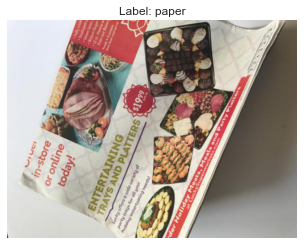

In [36]:
# Display sample images and their distributions per class for validation set
classes = val_df['label_name'].unique()

for label in classes:
    sample = val_df[val_df['label_name'] == label].iloc[0]
    img_path = str(data_dir)+'/'+sample['label_name']+"/"+str(sample['picture'])
    dimensions = []
    img = Image.open(img_path)
    dimensions.append(img.size)
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    
    dim_df = pd.DataFrame(dimensions, columns=['width', 'height'])
    print(dim_df.describe())
    plt.show()

In [37]:
train_df.head()

,picture,label,label_name
0,cardboard202.jpg,3,cardboard
1,paper472.jpg,2,paper
2,paper522.jpg,2,paper
3,glass189.jpg,1,glass
4,glass325.jpg,1,glass


# Generators and iterators for each set

In [38]:
train_df['rel_path'] = train_df['label_name']+'/'+train_df['picture']
test_df['rel_path'] = test_df['label_name']+'/'+test_df['picture']
val_df['rel_path'] = val_df['label_name']+'/'+val_df['picture']

In [39]:
# Generators
train_generator = ImageDataGenerator(rescale = 1./255)

val_generator = ImageDataGenerator(rescale = 1./255)

test_generator = ImageDataGenerator(rescale = 1./255)

# Iterators
train_iterator = train_generator.flow_from_dataframe(train_df,
                                                     directory = data_dir,
                                                    x_col='rel_path',
                                                    y_col='label_name',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='categorical')

val_iterator = val_generator.flow_from_dataframe(val_df,
                                                 directory =  data_dir,
                                                    x_col='rel_path',
                                                    y_col='label_name',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='categorical')

test_iterator = test_generator.flow_from_dataframe(test_df,
                                                    directory = data_dir,
                                                    x_col='rel_path',
                                                    y_col='label_name',
                                                    target_size=(128, 128),
                                                    batch_size=512,
                                                    class_mode='categorical')

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 431 validated image filenames belonging to 6 classes.


# Modelling - preparation

In [40]:
# Model evaluation function
def evaluate_model(trained_model):
  accuracy = trained_model.history.history['accuracy']
  val_accuracy = trained_model.history.history['val_accuracy']
  loss = trained_model.history.history['loss']
  val_loss = trained_model.history.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [41]:
# Gather results for each model
model_name = []
test_loss = []
test_acc = []
train_params = []
non_train_params = []

# Models

## Model 1

In [42]:
# Architecture (CNN with MaxPooling)
model_I = Sequential()

model_I.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_I.add(MaxPooling2D(4, 4))

model_I.add(Conv2D(64, (3,3), activation='relu'))
model_I.add(MaxPooling2D(4, 4))

model_I.add(Conv2D(64, (3,3), activation='relu'))
model_I.add(MaxPooling2D(2, 2))

model_I.add(Flatten())
model_I.add(Dense(16, activation='relu'))
model_I.add(Dense(1, activation='sigmoid'))
model_I.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [43]:
# Model compilation
model_I.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
history = model_I.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=32)

Epoch 1/5
4/4 [==============================] - 38s 8s/step - loss: 0.5455 - accuracy: 0.6565 - val_loss: 0.4838 - val_accuracy: 0.8333
Epoch 2/5
4/4 [==============================] - 17s 3s/step - loss: 0.4707 - accuracy: 0.8333 - val_loss: 0.4542 - val_accuracy: 0.8333
Epoch 3/5
4/4 [==============================] - 15s 4s/step - loss: 0.4603 - accuracy: 0.8333 - val_loss: 0.4557 - val_accuracy: 0.8333
Epoch 4/5
4/4 [==============================] - 17s 4s/step - loss: 0.4550 - accuracy: 0.8333 - val_loss: 0.4576 - val_accuracy: 0.8333
Epoch 5/5
4/4 [==============================] - 18s 4s/step - loss: 0.4552 - accuracy: 0.8333 - val_loss: 0.4523 - val_accuracy: 0.8333


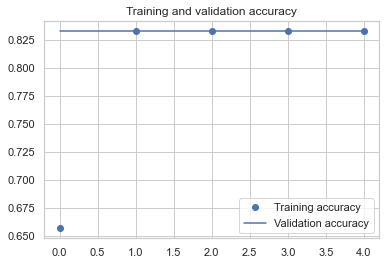

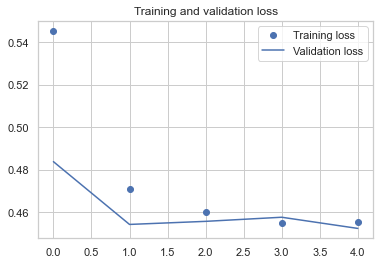

In [45]:
evaluate_model(model_I)

In [46]:
test_eval = model_I.evaluate(test_iterator, verbose=0)

In [47]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.452391117811203
Test accuracy: 0.833333432674408


## Model 2 (dropout)

In [48]:
# Architecture (CNN with MaxPooling and Dropout)
model_II = Sequential()

model_II.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_II.add(MaxPooling2D(4, 4))
model_II.add(Dropout(0.1))

model_II.add(Conv2D(64, (3,3), activation='relu'))
model_II.add(MaxPooling2D(4, 4))
model_II.add(Dropout(0.1))

model_II.add(Conv2D(64, (3,3), activation='relu'))
model_II.add(MaxPooling2D(2, 2))
model_II.add(Dropout(0.1))

model_II.add(Flatten())
model_II.add(Dense(16, activation='relu'))
model_II.add(Dense(1, activation='sigmoid'))
model_II.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)         

In [49]:
# Model compilation
model_II.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
history_II = model_II.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

Epoch 1/5
4/4 [==============================] - 19s 5s/step - loss: 0.5018 - accuracy: 0.8247 - val_loss: 0.4579 - val_accuracy: 0.8333
Epoch 2/5
4/4 [==============================] - 18s 4s/step - loss: 0.4637 - accuracy: 0.8333 - val_loss: 0.5087 - val_accuracy: 0.8333
Epoch 3/5
4/4 [==============================] - 17s 5s/step - loss: 0.4599 - accuracy: 0.8333 - val_loss: 0.4659 - val_accuracy: 0.8333
Epoch 4/5
4/4 [==============================] - 18s 4s/step - loss: 0.4588 - accuracy: 0.8333 - val_loss: 0.4653 - val_accuracy: 0.8333
Epoch 5/5
4/4 [==============================] - 16s 5s/step - loss: 0.4559 - accuracy: 0.8333 - val_loss: 0.4851 - val_accuracy: 0.8333


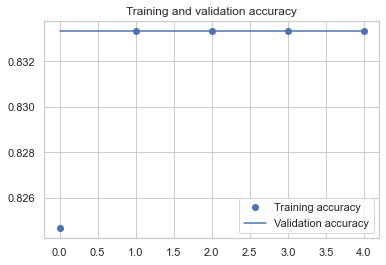

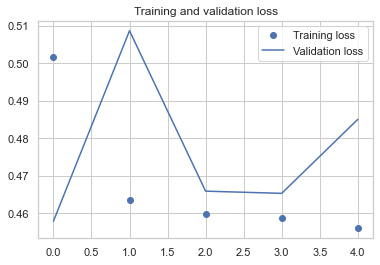

In [51]:
evaluate_model(model_II)

In [52]:
test_eval = model_II.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])   

Test loss: 0.48433151841163635
Test accuracy: 0.833333432674408


## Model 3 (normalization)

In [53]:

# Architecture (CNN with MaxPooling, Dropout and normalization)
model_III = Sequential()

model_III.add(Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)))
model_III.add(MaxPooling2D(4, 4))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.1))

model_III.add(Conv2D(64, (3,3), activation='relu'))
model_III.add(MaxPooling2D(4, 4))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.1))

model_III.add(Conv2D(64, (3,3), activation='relu'))
model_III.add(MaxPooling2D(2, 2))
model_III.add(BatchNormalization())
model_III.add(Dropout(0.1))

model_III.add(Flatten())
model_III.add(Dense(16, activation='relu'))
model_III.add(Dense(1, activation='sigmoid'))
model_III.summary()  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)        

In [54]:
# Model compilation
model_III.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [55]:
history_III = model_III.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

Epoch 1/5
4/4 [==============================] - 28s 8s/step - loss: 0.5363 - accuracy: 0.7734 - val_loss: 0.6940 - val_accuracy: 0.3659
Epoch 2/5
4/4 [==============================] - 23s 5s/step - loss: 0.4864 - accuracy: 0.8265 - val_loss: 0.6885 - val_accuracy: 0.7012
Epoch 3/5
4/4 [==============================] - 19s 4s/step - loss: 0.4767 - accuracy: 0.8288 - val_loss: 0.6715 - val_accuracy: 0.8313
Epoch 4/5
4/4 [==============================] - 19s 4s/step - loss: 0.4685 - accuracy: 0.8330 - val_loss: 0.6373 - val_accuracy: 0.8333
Epoch 5/5
4/4 [==============================] - 22s 5s/step - loss: 0.4649 - accuracy: 0.8330 - val_loss: 0.6153 - val_accuracy: 0.8333


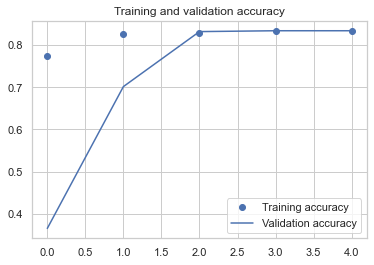

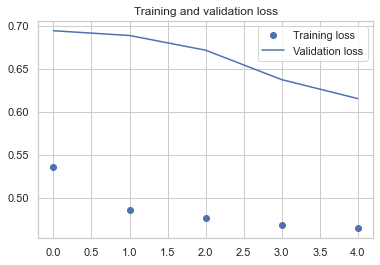

In [56]:
evaluate_model(model_III)

In [57]:
test_eval = model_III.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])    

Test loss: 0.6161053776741028
Test accuracy: 0.833333432674408


## Model 4

In [58]:
# Architecture (CNN with MaxPooling, Dropout, regularization, initialization and normalization)
model_IV = Sequential()

model_IV.add(Conv2D(32, (5,5), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer='glorot_uniform', activation='relu', input_shape=(128,128,3)))
model_IV.add(MaxPooling2D(4, 4))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.1))

model_IV.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer='glorot_uniform', activation='relu'))
model_IV.add(MaxPooling2D(4, 4))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.1))

model_IV.add(Conv2D(64, (3,3), kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), kernel_initializer='glorot_uniform', activation='relu'))
model_IV.add(MaxPooling2D(2, 2))
model_IV.add(BatchNormalization())
model_IV.add(Dropout(0.1))

model_IV.add(Flatten())
model_IV.add(Dense(16, activation='relu'))
model_IV.add(Dense(1, activation='sigmoid'))
model_IV.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 31, 31, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 64)        

In [59]:
# Model compilation
model_IV.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [60]:
history_IV = model_IV.fit(train_iterator, epochs=5, validation_data=val_iterator, batch_size=512)

Epoch 1/5
4/4 [==============================] - 21s 5s/step - loss: 0.5983 - accuracy: 0.7870 - val_loss: 0.6809 - val_accuracy: 0.8333
Epoch 2/5
4/4 [==============================] - 19s 4s/step - loss: 0.5315 - accuracy: 0.8205 - val_loss: 0.6682 - val_accuracy: 0.8333
Epoch 3/5
4/4 [==============================] - 19s 4s/step - loss: 0.5174 - accuracy: 0.8296 - val_loss: 0.6412 - val_accuracy: 0.8333
Epoch 4/5
4/4 [==============================] - 20s 5s/step - loss: 0.5116 - accuracy: 0.8330 - val_loss: 0.6132 - val_accuracy: 0.8333
Epoch 5/5
4/4 [==============================] - 20s 5s/step - loss: 0.5084 - accuracy: 0.8314 - val_loss: 0.5958 - val_accuracy: 0.8333


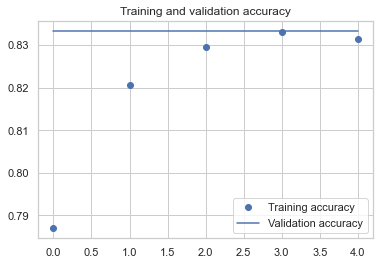

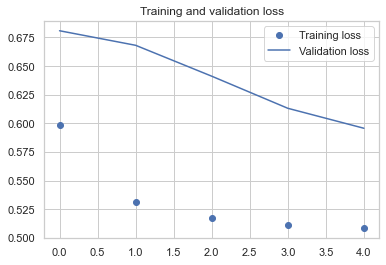

In [61]:
evaluate_model(model_IV)

In [62]:
test_eval = model_IV.evaluate(test_iterator, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])  

Test loss: 0.5959025621414185
Test accuracy: 0.833333432674408


## New model

In [63]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 128)     

In [64]:
# Train the model
history = model.fit(
    train_iterator,
    epochs=10,
    validation_data=val_iterator, batch_size=128
)

Epoch 1/10
4/4 [==============================] - 65s 17s/step - loss: 1.9888 - accuracy: 0.1776 - val_loss: 1.7830 - val_accuracy: 0.1402
Epoch 2/10
4/4 [==============================] - 43s 11s/step - loss: 1.7575 - accuracy: 0.2076 - val_loss: 1.6871 - val_accuracy: 0.2530
Epoch 3/10
4/4 [==============================] - 38s 11s/step - loss: 1.6563 - accuracy: 0.2732 - val_loss: 1.5764 - val_accuracy: 0.3689
Epoch 4/10
4/4 [==============================] - 44s 11s/step - loss: 1.5547 - accuracy: 0.3614 - val_loss: 1.5037 - val_accuracy: 0.3994
Epoch 5/10
4/4 [==============================] - 54s 16s/step - loss: 1.4545 - accuracy: 0.4457 - val_loss: 1.4199 - val_accuracy: 0.4268
Epoch 6/10
4/4 [==============================] - 45s 10s/step - loss: 1.3801 - accuracy: 0.4581 - val_loss: 1.4131 - val_accuracy: 0.4604
Epoch 7/10
4/4 [==============================] - 36s 10s/step - loss: 1.3362 - accuracy: 0.4610 - val_loss: 1.3616 - val_accuracy: 0.4634
Epoch 8/10
4/4 [===========

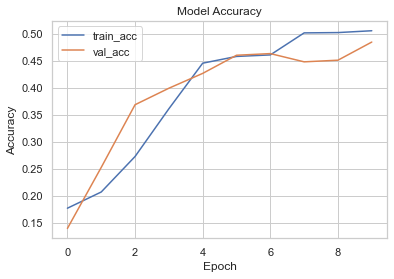

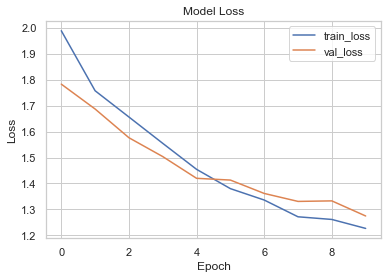

In [65]:
# Evaluate the model

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

In [66]:
# Confusionmatrix and classification report
# Predict on validation set
from sklearn.metrics import classification_report, confusion_matrix
val_iterator.reset()
preds = model.predict(val_iterator)
y_pred = np.argmax(preds, axis=1)
y_true = val_iterator.classes
class_labels = list(val_iterator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

1/1 [==============================] - 3s 3s/step
Classification Report:

              precision    recall  f1-score   support

   cardboard       0.14      0.20      0.17        46
       glass       0.11      0.06      0.08        65
       metal       0.25      0.14      0.18        56
       paper       0.16      0.16      0.16        83
     plastic       0.15      0.28      0.20        61
       trash       0.00      0.00      0.00        17

    accuracy                           0.16       328
   macro avg       0.14      0.14      0.13       328
weighted avg       0.15      0.16      0.15       328

Confusion Matrix:

[[ 9  2  4 16 15  0]
 [13  4  6 19 22  1]
 [ 6  7  8 14 19  2]
 [20 12  6 13 32  0]
 [ 8 10  8 17 17  1]
 [ 7  2  0  3  5  0]]
